# MAT201A Final Project
*   **Title:** Conditional Generative Adversarial Network (cGAN) Colorization
*   **Goal:** Black & white to colored images
*   **Dataset:** ImageNet/COCO-dataset
*   **Author:** Changzhi Cai, Nicole Han (My teammate in course ECE 283 - Machine Learning)

# Acknowledgement
    
  This project was completed by **Changzhi Cai** and teammate **Nicole Han** from course ECE 283. Changzhi mainly completed the **Architecture part**, and Nicole mainly completed the **Training part**. She has made a significant contribution to the success of this project, and thank her very much here.

# Algorithm
*   **Cost function V(D,G):** log(D(x)) + log(1- D(G(x)))
*   **Discrimnator (D):** maximize cost function (be able to give high probability for real x vs. generated x
*   **Generator (G):** minimize the cost function (confuses discriminator such that discriminator gives lower probability for real x vs. generated x, e.g. 50%), GAN loss+$\lambda$*l1 loss
*   **Optimization:** use minibatch, ADAM optimizer (lr = 0.0001 or .00005,
momentum β1 = 0.5, β2 = 0.999.)
*   **Regularization:** try both L1 & L2 for G




# Introduction
* Significant advancements have been made in photography over the past century with the earliest photographs limited by the technology of the time to black and white (greyscale) colors.  Now, with the development of artificial intelligence and machine learning technology, these early photographs may be enhanced to display full color information.  Colorizing black and white images is not only useful for enhancing historical photographs, but also to gain additional information about the contents of images not readily apparent in greyscale format such as in material identification or object classification.  Here we present a Conditional Generative Adversarial Network (cGAN) to realize such a coloring function of greyscale images.

* Early work in this area, Gatys et al. [1-3], proposed a method capable of artistic style conversion. The key to this method was to use the separability of the content and style characteristics of the image in the convolutional neural network to extract the different feature information from the image.  The features describing the image can then be separated from that describing the style.  Likewise, the style-specific features extracted from an image could be combined with the content-specific features of another image resulting in a new image with style transferred from one image to the next.  However, we found that this method was ineffective for colorizing greyscale images since the style was not equivalent to the attribute of color.

* In 2014, Goodfellow et al. [4] proposed the groundbreaking method of Generational Adversarial Networks (GAN). The technique is comprised of a generator model and a discriminator model, which act together to form a generative function of relevant image content that passes the realism checks of the discriminator. For our network, the generator model produces an image that deceives the discriminator model, which judges whether the image produced is real or not.  The network optimization iterates the two models against the training data set.  As the training process progresses, the realism of the generator model and performance of the discriminator model improve until a steady-state condition is reached. With the help of this game-style optimization, the GAN may generate realistic, high-quality images.  Problems occur when the training is too open-ended.  For example, when GANs to colorize greyscale images without specific constraints, deformed results are produced with the same color filling in unrelated areas.

* Our work presents an implementation of a cGAN to colorize greyscale images based on the invariance of the underlying information and the rationality of coloring [5].  The framework is based on a GAN-based image style transfer method proposed by Isola et al. in 2017 [6].  The network includes a generator model and a discriminator model.  PyTorch is used to train network parameters.  Parallel processing on the GPU was provided by Google Colab.  The result of this network is a network model that may quickly and automatically colorize a black-and-white (greyscale) photograph or image.

In [0]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
# authorization code: 4/0wHbEyjVofYAJ-k7ZvwCEl8oVrBhOQeWoJ1eoFzs7DjJy4tuPENXIlI

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# Import packages
import numpy as np
import math
import os
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
from torch.utils import data
from torch.nn.utils import spectral_norm
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import torch.optim as optim
from torch.autograd import Variable
print(torch.__version__) # 1.0.1
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy(), interpolation='nearest')

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
1.5.0+cu101


In [0]:
# make sure go to the project path
project_path = "/gdrive/My Drive/Changzhi_201A_Project"
os.chdir(project_path)
!ls

Color_GAN_Changzhi.ipynb  Dataset_Beach      Dataset_Flower  Trained_Models
Dataset			  Dataset_Buildings  Dataset_Nature


In [0]:
# CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## Load Dataset

*   **Dataset 1:** CIFAR-10 dataset

    https://www.cs.toronto.edu/kriz/cifar.html
*   **Dataset 2:** Scene-classification dataset from kaggle

    https://www.kaggle.com/nitishabharathi/scene-classification



In [0]:
#download cocodataset into google drive
# !wget http://images.cocodataset.org/zips/train2017.zip
# !unzip train2017.zip

In [0]:
# load_data
def load_data(data_folder, batch_size, train):
  '''
    PARAMETERS: 
      data_folder: path to dataset (make sure you're in project folder)
      batch_size: how many images in a batch
      train: boolean True/False

    RETURN:
      data_loader with random sample with batch_size from either "train" or "test" dataset
  '''
  transform = {
    'train': transforms.Compose(
        [transforms.Resize([64, 64]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                   std=[0.229, 0.224, 0.225])
            ]),
    'test': transforms.Compose(
        [transforms.Resize([64, 64]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                   std=[0.229, 0.224, 0.225])
            ])
  }
  data = torchvision.datasets.ImageFolder(root = data_folder, transform=transform['train' if train else 'test'])
  data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=4)
  return data_loader 

In [0]:
b_size = 128
# set up datafolder and read data
datafolder = "Dataset_Nature"
train_data = load_data(data_folder = datafolder, batch_size = b_size , train = True)  #128 training images
test_data = load_data(data_folder = datafolder, batch_size = b_size , train = True)  

# dataiter for iterating data randomly 
train_dataiter = iter(train_data)
test_dataiter = iter(test_data)

In [0]:
train_real, labels = train_dataiter.next() #get one batch of train data
print(train_real.shape) # images are in batch_size x channels(3) x width x height

torch.Size([128, 3, 64, 64])


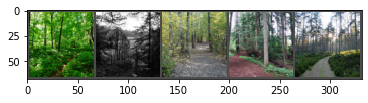

In [0]:
show_imgs(train_real[0:5,:,:,:])  #example of train data

## Architecture Overview
**(Changzhi's work)**

* The goal of GANs is to generate plausible output images from random noise vectors. For our cGAN model, the generation of output images is conditional on the category of input greyscale images. The discriminator is provided with both the colorized image and a copy of the original grayscale image, which it uses to determine whether the colorized image is a plausible transformation of the grayscale image.

* The model includes two networks:  a discriminator D and a generator G. Both networks contain modules based on convolution, normalization, andregularization (e.g., LeakyReLU). Batch normalization is used in both networks to stabilize the training.Attempting to use ReLU led to images with fewercolor details and a large patch of single color dur-ing training. Therefore, we used LeakyReLU withslope of 0.2 in all layers except the very last layer ofdiscriminator and generator, which used a differentactivation function.

* The training is a mini-max game between discrim-inator and generator.  The discriminator’s goal is to assign a high probability to real images and lowprobability to fake images. Meanwhile, the generator attempts to trick the discriminator by creating fake, colorized images that pass the discriminator’srealism checks. Both the discriminator and generator are trained concurrently and conditioned onthe category of the input image x (e.g.,  flowers).

### Discriminator

*   **Goal:** Assign a high probability to real images and low probability to fake images
*   **Input:** 4x64x64 grayscale image and colorful image embedded with noise
*   **Output:** A probability of the image being real
*   **Architecture:** CD64-Average Pooling-CD128-CD256-Max Pooling-CD256-Max Pooling-FC


In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim= 3*64*64, alpha=0.2, kernel_size = 4, padding = 1, stride = 1):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Dropout(0.25),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Dropout(0.25),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Dropout(0.5),
            nn.MaxPool2d(2)
            
        )
        self.prelu = nn.PReLU()
        self.drop = nn.Dropout(.5)
        self.fc1 = nn.Linear(256*6*6, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
      x = self.net(x)
      x = x.view(x.size(0), 256*6*6) #flattening x
      x = self.fc1(x)
      x = self.prelu(x)
      x = self.drop(x)
      x = self.fc2(x)
      x = torch.sigmoid(x.squeeze())
      return x

    def weight_initial(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

### Generator

*   **Goal:** Trick the discriminator by creatingfake, colorized images that pass the discriminator’srealism checks
*   **Input:** 2x64x64 grayscale image concatenated with noise
*   **Output:** A fake RGB image of size 3x64x64
*   **Architecture:** C16-C32-Max Pooling-C64-Max Pooling-C128-C256-Upsample-C128-Upsample-C64-Cat(Input)-C32-C3

In [0]:
class Generator(nn.Module):
  def __init__(self, input_size = 64*64, alpha = .2, kernel_size = 3, padding = 1, output_padding = 1, stride = 1):
    super(Generator, self).__init__()

    self.conv1 = nn.Sequential(
            nn.Conv2d(1+1, 16, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(alpha))
            # nn.ReLU())
    
    self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(32),
            # nn.ReLU(),
            nn.LeakyReLU(alpha),
            nn.MaxPool2d(2))
    
    self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            # nn.ReLU(),
            nn.LeakyReLU(alpha),
            nn.MaxPool2d(2))
    
    self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            # nn.ReLU())
            nn.LeakyReLU(alpha))
    
    self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(256),
            # nn.ReLU())
            nn.LeakyReLU(alpha))
    
    self.conv6 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            # nn.ReLU())
            nn.LeakyReLU(alpha))
    
    self.conv7 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            # nn.ReLU())
            nn.LeakyReLU(alpha))
    
    self.conv8 = nn.Sequential(
        nn.Conv2d(64+2, 32, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(32),
        # nn.ReLU())
        nn.LeakyReLU(alpha))
    
    self.conv9 = nn.Sequential(
        nn.Conv2d(32, 3, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(3),
        # nn.ReLU())
        nn.LeakyReLU(alpha))
        
    self.upsample = nn.Upsample(scale_factor=2)
  

  def forward(self, x):
    x_n = x
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.upsample(x)
    x = self.conv6(x)
    x = self.upsample(x)
    x = self.conv7(x)
    x = torch.tanh(x)
    x = torch.cat((x, x_n),1)
    x = self.conv8(x)
    x = self.conv9(x)

    x = torch.tanh(x)
    return x

  def weight_initial(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))
      if isinstance(m, nn.ConvTranspose2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))

## Training
**(Nicole's work)**
*   **Image Scale:** All images were resized to size 64x64 and normalized to the range [-1,1] before being loaded into mini-batches of  128 images for training the network.

*   **Weights Initialization and Activation Function:** All the weights were initialized to zero-center normal distribution with standard deviation based on layer's kernel size and output channel size (\(stddev\) = $\sqrt{\frac{2}{\text{kernel area} \times \text{output channel}}}$).

    The discriminator's final output activation function is sigmoid, which outputs the probability of an image being real. We use tanh as the generator's output activation function, producing a fake RGB image of size 3x64x64 with all output values bounded between -1 and 1. 

*   **Optimization:** The network is optimized in iterative, alternating steps.  First we optimize one gradient descent step on the discriminator D, then optimize one step on generator G. As introduced in the original GAN paper, instead of minimizing $\log(1-D(x, G(x,z))$ when training G, we train to maximize $\log D(x, G(x,z))$. We used the Adam optimizer in PyTorch with learning rate=.0001, $\beta_1$=0.5 and $\beta_2=0.999$ to train both the discriminator and generator.


*   **Tranining Tricks:** During training, a couple of issues we encountered were that the discriminator learned too quickly at the beginning of the training and its loss dropped to zero, preventing further improvement of the generator. The result was that the generator failed to produce reasonable images and entered mode collapse.  To mitigate this,  we added label smoothing in the discriminator training such that the real images' labels were uniform in the range [.8,1] and fake images' labels were uniform in the range [0,.2] in order to prevent the discriminator from being too confident. We also used label flipping such that every two iterations the real and fake images' labels were flipped. Noises were added to the images before feeding into discriminator to make classification more difficult and prevent mode collapse.

In [0]:
def train(D, G, D_opt, G_opt, criterion, recon_loss, lmbda, num_e):
  '''
  PARAMTER:
    D: discriminator
    G: generator
    D_opt: discriminator Optimizer
    num_e: number of epoches
  '''
  
  LOSS = {}
  LOSS["D_loss"] = []
  LOSS["G_loss"] = []
  LOSS["D_grad_spar"] = []
  LOSS["G_grad_spar"] = []

  for e in range(num_e):
    train_dataiter = iter(train_data)
    print("epoch: %d start" % (e+1))
    D_loss = []
    D_grad_spar = []
    D_out_real = []
    D_out_fake = []
    G_loss = []
    G_grad_spar = []

    iter_train = 0
    for train_real, _ in train_dataiter: 
      iter_train += 1

      b_size = train_real.shape[0]

      ##############
      # D Training #
      ##############
      D_opt.zero_grad()
      train_real = train_real.to(device)
      # label smooth
      if iter_train %4 != 0: 
        lab_real, lab_fake = torch.FloatTensor(b_size).uniform_(.8,1).to(device), torch.FloatTensor(b_size).uniform_(0,.2).to(device)
      else: #1 real, 0 fake
        lab_real, lab_fake = torch.FloatTensor(b_size).uniform_(0,.2).to(device), torch.FloatTensor(b_size).uniform_(.8,1).to(device)

      # lab_real, lab_fake = torch.ones(b_size, 1, device=device), torch.zeros(b_size, 1, device=device) #labels 
      # corresponding grayscale images
      images = train_real.clone().cpu() 
      images = [torchvision.transforms.ToPILImage()(x) for x in images]
      images = [torchvision.transforms.Grayscale()(x) for x in images]
      images = [torchvision.transforms.ToTensor()(x) for x in images]
      train_real_gray = torch.stack(images).to(device)
      n_size = train_real_gray.size()

      # D Loss for real
      n = (torch.randn(n_size) * .1) # add noise to image to make it harder for discriminator
      n = n.to(device)
      train_real = train_real + n
      D_out = D(train_real)
      lossD_real = criterion(D_out, lab_real)      

      # D Loss for fake
      n = (torch.randn(n_size) * .1)
      n = n.to(device)
      train_real_gray = torch.cat((train_real_gray, n), 1)
      G_fake_out = G(train_real_gray)
      
      n = (torch.randn(n_size) * .1) # add noise to image to make it harder for discriminator
      n = n.to(device)
      G_fake_out = G_fake_out + n
      D_fake_out = D(G_fake_out.detach())
      lossD_fake = criterion(D_fake_out, lab_fake)

      # D Loss total
      lossD = lossD_real + lossD_fake
      lossD.backward()
      D_opt.step()

      D_out_real.append(D_out)
      # print("D_out_real: %f" % D_out.mean())
      D_out_fake.append(D_fake_out)
      # print("D_out_fake: %f" % D_fake_out.mean())
      D_loss.append(lossD)
      # print("D_loss: %f" % lossD)
      sparsity = []
      for param in D.parameters():
        spars = 1 - len(param.grad[abs(param.grad)>.001])/len(param.grad.view(-1,1))
        sparsity.append(spars)
      D_grad_spar.append(torch.mean(torch.tensor(sparsity))) #mean sparsity


      ##############
      # G Training #
      ##############
      G_opt.zero_grad()

      # G Loss + perceptual norm Loss between generated rgb image and groundtruth image
      D_G_out = D(G_fake_out)
      lossG = criterion(D_G_out, lab_real) #Loss for GAN LOSS
      lossG_L1 = recon_loss(G_fake_out.view(G_fake_out.size(0),-1), train_real.view(train_real.size(0),-1)) #Loss for output rgb and real rgb image
      LossGAN_L1 = lossG + lmbda * lossG_L1
      LossGAN_L1.backward()
      G_opt.step()

      G_loss.append(LossGAN_L1)
      # print("G_loss: %f" % LossGAN_L1)

      sparsity = []
      for param in G.parameters():
        spars = 1 - len(param.grad[abs(param.grad)>.001])/len(param.grad.view(-1,1))
        sparsity.append(spars)
      G_grad_spar.append(torch.mean(torch.tensor(sparsity))) #mean sparsity
      

    print(G_grad_spar)
    LOSS["D_loss"].append(torch.mean(torch.stack(D_loss)))
    LOSS["G_loss"].append(torch.mean(torch.stack(G_loss)))
    LOSS["D_grad_spar"].append(torch.mean(torch.stack(D_grad_spar)))
    LOSS["G_grad_spar"].append(torch.mean(torch.stack(G_grad_spar)))

    print("D_loss:%f" %torch.mean(torch.stack(D_loss)))
    print("G_loss:%f" %torch.mean(torch.stack(G_loss)))
    print("epoch %d finished" % (e+1))

    # if e % 10 == 0:
    #   print("test on 16 images:")
    #   test_dataiter = iter(test_data)
    #   test_real, _ = test_dataiter.next()
    #   test_images = test_real.clone().cpu() 
    #   test_images = [torchvision.transforms.ToPILImage()(x) for x in test_images]
    #   test_images = [torchvision.transforms.Grayscale()(x) for x in test_images]
    #   test_images = [torchvision.transforms.ToTensor()(x) for x in test_images]
    #   test_real_gray = torch.stack(test_images).to(device)

    #   test_img_orig = test_real[0:16,...]
    #   test_img_gray = test_real_gray[0:16,...]
    #   n = (torch.randn(test_img_gray.size()) * .1)
    #   n = n.to(device)
    #   G_test_out = G(torch.cat((test_img_gray, n), 1))
    #   show_imgs(test_img_orig)
    #   show_imgs(test_img_gray)
    #   show_imgs(G_test_out)
  
  return LOSS

In [0]:
def plot_history(d_hist, g_hist, d_spar, g_spar, e):
	# plot loss
	plt.subplot(2, 1, 1)
	plt.plot(d_hist, label='discriminator')
	plt.plot(g_hist, label='generator')
	plt.legend()
	plt.ylabel('Loss')
 
	# plot gradient sparsity
	plt.subplot(2, 1, 2)
	plt.plot(d_spar, label='discriminator')
	plt.plot(g_spar, label='generator')
	plt.legend()
	plt.ylabel('Gradient Sparsity')

	plt.savefig('/gdrive/My Drive/Changzhi_201A_Project/Trained_Models/Dataset_nature_results_%d.png' %e)
	plt.close()

In [0]:
G = Generator().to(device)
D = Discriminator().to(device)
D.weight_initial()
G.weight_initial()
G.train()
D.train()

h, w = 64, 64
D_lr = .0001
G_lr = .0001
beta1 = .5
lmbda = 200
num_e = 1000

criterion = nn.BCELoss()
L1loss = nn.L1Loss()
L2loss = nn.MSELoss()
D_opt = optim.Adam(D.parameters(), lr=D_lr, betas = (beta1, .999))
G_opt = optim.Adam(G.parameters(), lr=G_lr, betas = (beta1, .999))

In [0]:
# train
#num_e = 1000
num_e = 100
G = G.to(device)
D = D.to(device)
G.train()
D.train()
training_loss = train(D, G, D_opt, G_opt, criterion, L2loss, lmbda, num_e)

epoch: 1 start
[tensor(0.0439), tensor(0.0505), tensor(0.0441), tensor(0.0244), tensor(0.0226), tensor(0.0207), tensor(0.0319), tensor(0.0473), tensor(0.0508), tensor(0.0348), tensor(0.0143), tensor(0.0290), tensor(0.0343), tensor(0.0363), tensor(0.0212), tensor(0.0315), tensor(0.0246)]
D_loss:1.249447
G_loss:62.000538
epoch 1 finished
epoch: 2 start
[tensor(0.0282), tensor(0.0217), tensor(0.0333), tensor(0.0361), tensor(0.0462), tensor(0.0241), tensor(0.0270), tensor(0.0282), tensor(0.0427), tensor(0.0594), tensor(0.0512), tensor(0.0295), tensor(0.0282), tensor(0.0504), tensor(0.0400), tensor(0.0150), tensor(0.0177)]
D_loss:1.251742
G_loss:61.602871
epoch 2 finished
epoch: 3 start
[tensor(0.0245), tensor(0.0368), tensor(0.0378), tensor(0.0297), tensor(0.0405), tensor(0.0241), tensor(0.0340), tensor(0.0122), tensor(0.0256), tensor(0.0151), tensor(0.0208), tensor(0.0278), tensor(0.0396), tensor(0.0447), tensor(0.0255), tensor(0.0403), tensor(0.0254)]
D_loss:1.249804
G_loss:61.478558
epo

In [0]:
# save model
import datetime
import pickle

date = datetime.datetime.now().isoformat(' ', 'seconds')[5:10]

#e = 1000
e = 100
D_path = "/gdrive/My Drive/Changzhi_201A_Project/Trained_Models/D_%d_%s.pth.tar" % (e,date)
G_path = "/gdrive/My Drive/Changzhi_201A_Project/Trained_Models/G_%d_%s.pth.tar" % (e,date)
torch.save(D.state_dict(), D_path)
torch.save(G.state_dict(), G_path)
pickle.dump(training_loss, open("LOSS_%d.p"%e, "wb" ) )

d_hist = training_loss["D_loss"]
g_hist = training_loss["G_loss"]
d_spar = training_loss["D_grad_spar"]
g_spar = training_loss["G_grad_spar"]
plot_history(d_hist, g_hist, d_spar, g_spar, e = e)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [0]:
# load model
# D_path = "/gdrive/My Drive/Colab Notebooks/GAN/Flower/Colorizer_D_1001_05-28.pth.tar"
# G_path = "/gdrive/My Drive/Colab Notebooks/GAN/Flower/Colorizer_G_1001_05-28.pth.tar"

D = Discriminator()
D.load_state_dict(torch.load(D_path))
G = Generator()
G.load_state_dict(torch.load(G_path))
G.eval()
D.eval()

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2)
    (9): Dropout(p=0.25, inplace=False)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2)
    (13): Dropout(p=0.5, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (prelu): PReLU(num_parameters=1)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_

test on 16 images:


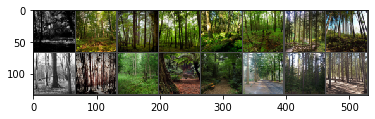

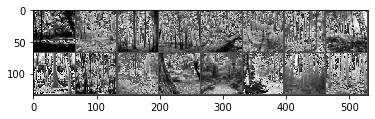

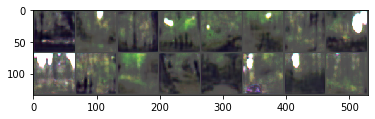

In [0]:
print("test on 16 images:")
test_dataiter = iter(test_data)
test_real, _ = test_dataiter.next()
test_images = test_real.clone().cpu() 
test_images = [torchvision.transforms.ToPILImage()(x) for x in test_images]
test_images = [torchvision.transforms.Grayscale()(x) for x in test_images]
test_images = [torchvision.transforms.ToTensor()(x) for x in test_images]
test_real_gray = torch.stack(test_images).cpu()

test_img_orig = test_real[0:16,...]
test_img_gray = test_real_gray[0:16,...]
n = (torch.randn(test_img_gray.size()) * .1)
G_test_out = G(torch.cat((test_img_gray, n), 1))
show_imgs(test_img_orig)
show_imgs(test_img_gray)
show_imgs(G_test_out)

# Reference

[1] Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). A neural algorithm of artistic style. arXiv preprint arXiv:1508.06576.

[2] Gatys, L. A., Ecker, A. S., & Bethge, M. (2016). Image style transfer using convolutional neural networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2414-2423).

[3] Johnson, J., Alahi, A., & Fei-Fei, L. (2016, October). Perceptual losses for real-time style transfer and super-resolution. In European conference on computer vision (pp. 694-711). Springer, Cham.

[4] Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680).

[5] Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784.

[6]  Isola, P., Zhu, J. Y., Zhou, T., & Efros, A. A. (2017). Image-to-image translation with conditional adversarial networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1125-1134).